In [1]:
import math
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from my_ecog_utils import read_with_annotations, get_multitaper_power_bands
from typing import Literal

TODO rerun w new frequency bands. Import lib prn. -12/14

In [2]:
from pactools import raw_to_mask, Comodulogram
import math
from typing import Literal
from scipy.cluster.vq import kmeans

mne.set_log_level('ERROR')
pac_list = []
for pt_num in [100, 105, 109, 110, 112, 113, 115]:
    for chan in range(4):
        raw = read_with_annotations(pt_num)
        raw.load_data()
        raw.notch_filter(62.5)

        if pt_num == 100 and chan >= 2:
            print(raw.info['ch_names'])
            continue
        elif pt_num == 105 and chan >= 2:
            print(raw.info['ch_names'])
            continue
        elif pt_num == 109 and chan >= 3:
            print(raw.info['ch_names'])
            continue

        evts, _ = mne.events_from_annotations(raw, {'post_shock': 2})
        centroids, _ = kmeans(evts[:,0].astype(float), 3)
        centroids = np.sort(centroids)

        get_trial = lambda x: np.argmin(np.abs(centroids - x)) + 1
        trial_nums = np.apply_along_axis(lambda row: get_trial(row[0]), 1, evts)
        # trial_nums = np.array([1,2,3])

        for trial in range(1,4):
            # filter down to the events from this trial
            evts_trial = np.take(evts, np.nonzero(trial_nums == trial), axis=0)
            # evts_trial = np.take(evts, np.where(trial_nums == trial)[0][0], axis=0)
            evts_trial = evts_trial.reshape(1, -1)

            tmin = 0
            tmax = 1
            # ixs determines what channel to look at
            low_sig, high_sig, mask = raw_to_mask(raw, ixs=chan, events=evts_trial, tmin=tmin, tmax=tmax)
            lo_th = 4
            hi_th = 8
            estimator = Comodulogram(
                fs=raw.info['sfreq'],
                low_fq_range=np.linspace(lo_th,hi_th,24), low_fq_width=2.0,
                method='tort', progress_bar=True, # tort is better for short signals, says Hulsemann 2019
                n_surrogates=10, n_jobs=2)
            estimator.fit(low_sig, high_sig, mask)
            # estimator.plot(tight_layout=False, contour_method='comod_max', contour_level=0.10, axs=ax)
            get_fq_index = lambda fq: math.floor((fq-(hi_th+1))/((125-(hi_th+1))/estimator.comod_.shape[2]))
            print(estimator.get_maximum_pac())
            common = {
                'pt_num': pt_num,
                'chan': raw.info['ch_names'][chan],
                'trial': trial,
            }
            pac_list.append({
                **common,
                'freq': 'alpha',
                'pac': np.mean(estimator.comod_[0][:,0:get_fq_index(12)])
            })
            pac_list.append({
                **common,
                'freq': 'beta',
                'pac': np.mean(estimator.comod_[0][:,get_fq_index(13):get_fq_index(30)])
            })
            pac_list.append({
                **common,
                'freq': 'low_gamma',
                'pac': np.mean(estimator.comod_[0][:,get_fq_index(40):get_fq_index(57)])
            })
            pac_list.append({
                **common,
                'freq': 'high_gamma',
                'pac': np.mean(estimator.comod_[0][:,get_fq_index(67):get_fq_index(100)])
            })

[........................................] 100% | 22.38 sec | comodulogram: tort 
(array([4.]), array([125.]), array([0.03333544]))
[........................................] 100% | 17.18 sec | comodulogram: tort 
(array([4.]), array([74.64556962]), array([0.02927524]))
[........................................] 100% | 19.25 sec | comodulogram: tort 
(array([4.17391304]), array([125.]), array([0.03563632]))
[........................................] 100% | 20.12 sec | comodulogram: tort 
(array([4.86956522]), array([125.]), array([0.0538262]))
[........................................] 100% | 18.56 sec | comodulogram: tort 
(array([4.]), array([19.84810127]), array([0.03219241]))
[........................................] 100% | 16.09 sec | comodulogram: tort 
(array([4.69565217]), array([46.50632911]), array([0.02639979]))
['Hip1 - Hip2', 'Hip3 - Hip4', 'LatT1 - LatT2', 'LatT3 - LatT4']
['Hip1 - Hip2', 'Hip3 - Hip4', 'LatT1 - LatT2', 'LatT3 - LatT4']
[.................................

In [70]:
df_pac = pd.DataFrame(pac_list)
df_pac

pt_num           chan  trial        freq       pac
0       100    Hip1 - Hip2      1       alpha  0.007938
1       100    Hip1 - Hip2      1        beta  0.009280
2       100    Hip1 - Hip2      1   low_gamma  0.011468
3       100    Hip1 - Hip2      1  high_gamma  0.007580
4       100    Hip1 - Hip2      2       alpha  0.008643
..      ...            ...    ...         ...       ...
271     115  RHip3 - RHip4      2  high_gamma  0.007466
272     115  RHip3 - RHip4      3       alpha  0.005241
273     115  RHip3 - RHip4      3        beta  0.007218
274     115  RHip3 - RHip4      3   low_gamma  0.007500
275     115  RHip3 - RHip4      3  high_gamma  0.006239

[276 rows x 5 columns]

get memory data

In [4]:
import pandas as pd
memory_trials = pd.read_csv('memory_delayed.csv')

In [5]:
memory_trials

Unnamed: 0   ID  Memory_Stim  Memory_Sham
0            0  100          4.0            5
1            1  101          4.0            4
2            2  102          7.0            8
3            3  103         10.0            8
4            4  104          3.0            0
5            5  105          3.0            3
6            6  106         12.0           11
7            7  107         10.0            0
8            8  108          6.0            5
9            9  109          6.0            6
10          10  110          5.0            4
11          11  111          8.0            0
12          12  112          9.0           10
13          13  113          8.0            8
14          14  115          4.0            5
15          15  200          4.0            1
16          16  201          NaN            7
17          17  202          5.0            2
18          18  205          NaN            0
19          19  206          6.0            3
20          20  207          9.0            0
21          21  208          8.0            0
22          22  209          4.0            0

In [6]:
selected_avg = memory_trials[memory_trials['ID'].isin([101, 102, 103, 104, 106, 108, 200, 202, 206])]
from scipy.stats import ttest_rel
ttest_rel(selected_avg['Memory_Stim'], selected_avg['Memory_Sham'])

Ttest_relResult(statistic=3.3333333333333335, pvalue=0.010333054606944121)

In [7]:
selected_avg = memory_trials[memory_trials['ID'].isin([100, 105, 109, 110, 111, 112, 113, 115])]
from scipy.stats import ttest_rel
ttest_rel(selected_avg['Memory_Stim'], selected_avg['Memory_Sham'])

Ttest_relResult(statistic=0.7043173944508146, pvalue=0.5039855405717248)

In [8]:
memory_trials = pd.read_csv('memory_trials.csv').iloc[:,1:]
# 111 has to be dropped from trial-level analyses because they only have 2 recorded trials
# so we don't know whether trials 1 and 2 were recorded or trials 2 and 3
memory_trials = memory_trials.drop(11, axis=0)
memory_trials['ID'] = memory_trials['ID'].astype(int)
memory_trials

ID  Trial_1_Stim  Trial_2_Stim  Trial_3_Stim  Trial_1_Sham  Trial_2_Sham  \
0   100             4             6             6             7             7   
1   101             3             5             6             5             6   
2   102             7            10            11             4             8   
3   103             7             8            10             7             6   
4   104             4             4             6             5             6   
5   105             5             7             7             7             6   
6   106             8            10            12             9            10   
7   107             7            10            10             0             0   
8   108             2             5             7             4             7   
9   109             4             7             9             5             7   
10  110             5             5             7             7             7   
12  112             8             9            10             5             9   
13  113             7             9             9             6             8   
14  115             4             6             5             4             4   
15  200             4             3             5             2             2   
16  201             6             6             7             7             6   
17  202             4             5             7             4             5   
18  205             5             5             6             0             0   
19  206             4             7             7             6             5   
20  207             6             9             9             0             0   
21  208             5             8            11             0             0   
22  209             5             6             8             0             0   

    Trial_3_Sham   Avg_Sham  
0              9   7.666667  
1              9   6.666667  
2              8   6.666667  
3              7   6.666667  
4              5   5.333333  
5              7   6.666667  
6             12  10.333333  
7              0   0.000000  
8              6   5.666667  
9              9   6.666667  
10             8   7.333333  
12             8   7.333333  
13             8   7.333333  
14             7   5.000000  
15             4   2.666667  
16             8   7.000000  
17             7   5.333333  
18             0   0.000000  
19             5   5.333333  
20             0   0.000000  
21             0   0.000000  
22             0   0.000000

In [9]:
memory_trials = memory_trials.set_index(['ID', 'Avg_Sham']).stack().to_frame()
memory_trials['Trial'] = memory_trials.index.get_level_values(2)
memory_trials['Trial'] = memory_trials['Trial'].str[len('Trial_')].astype(int)
memory_trials = memory_trials.reset_index(level=2)
memory_trials = memory_trials[~memory_trials['level_2'].str.endswith('Sham')]
memory_trials = memory_trials.drop('level_2', axis=1)
memory_trials = memory_trials.rename(columns={0: 'Memory_Score'})
memory_trials = memory_trials.reset_index(level=1)
memory_trials

Avg_Sham  Memory_Score  Trial
ID                                
100  7.666667             4      1
100  7.666667             6      2
100  7.666667             6      3
101  6.666667             3      1
101  6.666667             5      2
..        ...           ...    ...
208  0.000000             8      2
208  0.000000            11      3
209  0.000000             5      1
209  0.000000             6      2
209  0.000000             8      3

[66 rows x 3 columns]

In [10]:
np.setdiff1d(memory_trials.index.unique(), [100, 105, 109, 110, 111, 112, 113, 115])

array([101, 102, 103, 104, 106, 107, 108, 200, 201, 202, 205, 206, 207,
       208, 209], dtype=int64)

In [11]:
selected_mem = memory_trials[memory_trials.index.isin([101, 102, 103, 104, 106, 108, 200, 201, 202, 206])]
selected_avg = selected_mem.groupby(['ID']).mean()
from scipy.stats import ttest_rel
ttest_rel(selected_avg['Memory_Score'], selected_avg['Avg_Sham'])

Ttest_relResult(statistic=0.374415432874875, pvalue=0.7167647655155305)

In [12]:
selected_avg

Avg_Sham  Memory_Score  Trial
ID                                 
101   6.666667      4.666667    2.0
102   6.666667      9.333333    2.0
103   6.666667      8.333333    2.0
104   5.333333      4.666667    2.0
106  10.333333     10.000000    2.0
108   5.666667      4.666667    2.0
200   2.666667      4.000000    2.0
201   7.000000      6.333333    2.0
202   5.333333      5.333333    2.0
206   5.333333      6.000000    2.0

In [13]:
mem_avg = memory_trials.groupby('ID').mean()

In [14]:
memory_trials

Avg_Sham  Memory_Score  Trial
ID                                
100  7.666667             4      1
100  7.666667             6      2
100  7.666667             6      3
101  6.666667             3      1
101  6.666667             5      2
..        ...           ...    ...
208  0.000000             8      2
208  0.000000            11      3
209  0.000000             5      1
209  0.000000             6      2
209  0.000000             8      3

[66 rows x 3 columns]

In [15]:
mem_avg = mem_avg.drop([207, 208, 209])

In [16]:
ttest_rel(mem_avg['Memory_Score'], mem_avg['Avg_Sham'])

Ttest_relResult(statistic=1.22901741175401, pvalue=0.234890791114532)

In [17]:
pac_and_mem = df_pac.merge(memory_trials, left_on=['pt_num', 'trial'], right_on=['ID', 'Trial'], how='left')

In [18]:
pac_and_mem

pt_num           chan  trial        freq       pac  Avg_Sham  \
0       100    Hip1 - Hip2      1       alpha  0.007938  7.666667   
1       100    Hip1 - Hip2      1        beta  0.009280  7.666667   
2       100    Hip1 - Hip2      1   low_gamma  0.011468  7.666667   
3       100    Hip1 - Hip2      1  high_gamma  0.007580  7.666667   
4       100    Hip1 - Hip2      2       alpha  0.008643  7.666667   
..      ...            ...    ...         ...       ...       ...   
271     115  RHip3 - RHip4      2  high_gamma  0.007466  5.000000   
272     115  RHip3 - RHip4      3       alpha  0.005241  5.000000   
273     115  RHip3 - RHip4      3        beta  0.007218  5.000000   
274     115  RHip3 - RHip4      3   low_gamma  0.007500  5.000000   
275     115  RHip3 - RHip4      3  high_gamma  0.006239  5.000000   

     Memory_Score  Trial  
0               4      1  
1               4      1  
2               4      1  
3               4      1  
4               6      2  
..            ...    ...  
271             6      2  
272             5      3  
273             5      3  
274             5      3  
275             5      3  

[276 rows x 8 columns]

In [19]:
pac_and_mem.to_csv('post_pac_and_mem2.csv')

In [20]:
%matplotlib inline

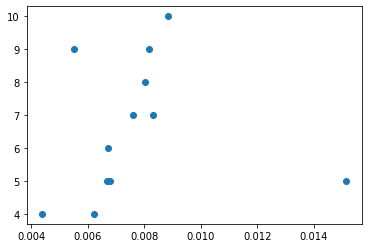

In [21]:
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'LHip1 - LHip2')]
plt.scatter(df_filtered['pac'], df_filtered['Memory_Score'])

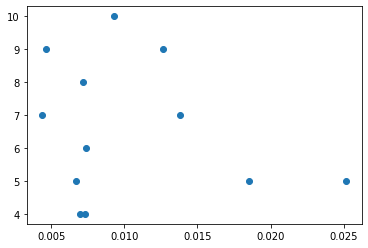

In [22]:
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'LHip3 - LHip4')]
plt.scatter(df_filtered['pac'], df_filtered['Memory_Score'])

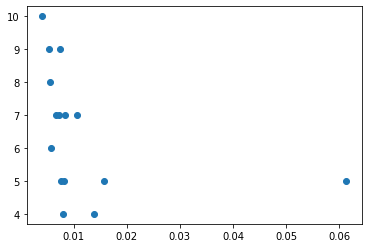

In [23]:
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'RHip1 - RHip2')]
plt.scatter(df_filtered['pac'], df_filtered['Memory_Score'])

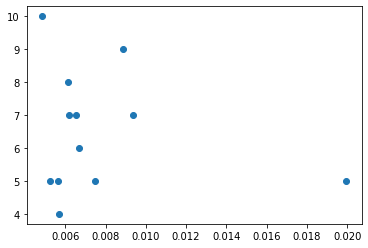

In [24]:
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'RHip3 - RHip4')]
plt.scatter(df_filtered['pac'], df_filtered['Memory_Score'])

In [25]:
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

In [26]:
from scipy.stats import kendalltau
for hip_ch in hip_chans:
    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == hip_ch)]
    print(kendalltau(df_filtered['pac'], df_filtered['Memory_Score']))

KendalltauResult(correlation=0.4131671220064233, pvalue=0.07006258632483754)
KendalltauResult(correlation=-0.06356417261637282, pvalue=0.7804802770694984)
KendalltauResult(correlation=-0.5422012617727135, pvalue=0.007205235609824049)
KendalltauResult(correlation=-0.048911598804451846, pvalue=0.8321417682696266)


In [27]:
from scipy.stats import kendalltau, linregress
for hip_ch in hip_chans:
    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == hip_ch)]
    print(linregress(df_filtered['pac'], df_filtered['Memory_Score']))

LinregressResult(slope=58.39768028001898, intercept=6.133914780792735, rvalue=0.07555304616001143, pvalue=0.8154765515633242, stderr=243.72525432641956, intercept_stderr=1.9765804582509203)
LinregressResult(slope=-69.02616168132683, intercept=7.296050254858924, rvalue=-0.20833048857450784, pvalue=0.515845189771089, stderr=102.47683854836062, intercept_stderr=1.2221256612632063)
LinregressResult(slope=-47.44639030771028, intercept=7.088261998085773, rvalue=-0.35473609562649433, pvalue=0.19449894865046305, stderr=34.68343926735271, intercept_stderr=0.6224983506264973)
LinregressResult(slope=-85.38167808266992, intercept=7.1594518392624895, rvalue=-0.19039015738719733, pvalue=0.5533806472151117, stderr=139.22035812088868, intercept_stderr=1.2055627572385745)


In [28]:
from scipy.stats import kendalltau
for hip_ch in hip_chans:
    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'high_gamma') & (pac_and_mem['chan'] == hip_ch)]
    print(kendalltau(df_filtered['pac'], df_filtered['Memory_Score']))

KendalltauResult(correlation=0.3813850356982369, pvalue=0.09449292670947168)
KendalltauResult(correlation=-0.12712834523274563, pvalue=0.5772634476440937)
KendalltauResult(correlation=-0.05115106243138807, pvalue=0.799874085728541)
KendalltauResult(correlation=-0.048911598804451846, pvalue=0.8321417682696266)


In [29]:
from scipy.stats import kendalltau, linregress
for hip_ch in hip_chans:
    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'high_gamma') & (pac_and_mem['chan'] == hip_ch)]
    print(linregress(df_filtered['pac'], df_filtered['Memory_Score']))

LinregressResult(slope=318.99276155369046, intercept=4.408870495266578, rvalue=0.30105870695048786, pvalue=0.3416544065812852, stderr=319.5202833151244, intercept_stderr=2.258201925740088)
LinregressResult(slope=-132.40713006814852, intercept=7.6373031887480884, rvalue=-0.23648018265577214, pvalue=0.4593039531467398, stderr=172.0364044048067, intercept_stderr=1.4981399991171327)
LinregressResult(slope=-69.44340987127005, intercept=7.078996907209404, rvalue=-0.09824552334079287, pvalue=0.7275868639160364, stderr=195.09245128886113, intercept_stderr=1.6132532323374047)
LinregressResult(slope=-111.17104806259078, intercept=7.301663879108047, rvalue=-0.1074353518011954, pvalue=0.7396352139953104, stderr=325.3295572137968, intercept_stderr=2.4100606546338557)


In [30]:
pre_pac = pd.read_csv('pre_pac_and_mem.csv')

In [31]:
from scipy.stats import kendalltau, linregress
for hip_ch in hip_chans:
    df_filtered = pre_pac[(pre_pac['freq'] == 'low_gamma') & (pre_pac['chan'] == hip_ch)]
    print(kendalltau(df_filtered['pac'], df_filtered['Memory_Score']))

KendalltauResult(correlation=-0.5512459105263765, pvalue=0.04321958717379089)
KendalltauResult(correlation=-0.08703882797784893, pvalue=0.7495770513840853)
KendalltauResult(correlation=-0.505419854312669, pvalue=0.028509256127898282)
KendalltauResult(correlation=-0.2771657265585605, pvalue=0.22971976545345274)


In [32]:
from scipy.stats import kendalltau, linregress
for hip_ch in hip_chans:
    df_filtered = pre_pac[(pre_pac['freq'] == 'high_gamma') & (pre_pac['chan'] == hip_ch)]
    print(kendalltau(df_filtered['pac'], df_filtered['Memory_Score']))

KendalltauResult(correlation=-0.08703882797784893, pvalue=0.7495770513840853)
KendalltauResult(correlation=-0.08703882797784893, pvalue=0.7495770513840853)
KendalltauResult(correlation=-0.5380275868489702, pvalue=0.01972646961560215)
KendalltauResult(correlation=-0.17934252894965677, pvalue=0.4370584278375953)


In [33]:
from scipy.stats import kendalltau, linregress
for hip_ch in hip_chans:
    df_filtered = pre_pac[(pre_pac['freq'] == 'low_gamma') & (pre_pac['chan'] == hip_ch)]
    print(linregress(df_filtered['pac'], df_filtered['Memory_Score']))

LinregressResult(slope=-112.00100037800064, intercept=12.015056949003121, rvalue=-0.7673686456140564, pvalue=0.015788504440786562, stderr=35.3725630378023, intercept_stderr=1.7878311805666465)
LinregressResult(slope=-26.008019897565138, intercept=7.588702523819753, rvalue=-0.1443123127232808, pvalue=0.7110638909281288, stderr=67.40386637697185, intercept_stderr=2.775110483870993)
LinregressResult(slope=-77.44093507314896, intercept=9.753826173718142, rvalue=-0.7347763115444234, pvalue=0.006486996270235756, stderr=22.607021039701927, intercept_stderr=1.0218270443801596)
LinregressResult(slope=-55.83565719517355, intercept=8.781770118710668, rvalue=-0.3961949515378418, pvalue=0.20231318459235498, stderr=40.91891377700763, intercept_stderr=1.7481811025162817)


In [34]:
from scipy.stats import kendalltau, linregress
for hip_ch in hip_chans:
    df_filtered = pre_pac[(pre_pac['freq'] == 'high_gamma') & (pre_pac['chan'] == hip_ch)]
    print(linregress(df_filtered['pac'], df_filtered['Memory_Score']))

LinregressResult(slope=-3.7710964664058904, intercept=6.858197440770827, rvalue=-0.03441560327346503, pvalue=0.9299582732727436, stderr=41.39099688265288, intercept_stderr=3.4024412597448417)
LinregressResult(slope=-13.57263594499667, intercept=7.482634921198592, rvalue=-0.168468128537776, pvalue=0.6648133513798522, stderr=30.015481474258387, intercept_stderr=2.175120142890297)
LinregressResult(slope=-34.043896577549994, intercept=8.516466324064764, rvalue=-0.5618146729569752, pvalue=0.05729786263696193, stderr=15.852211194888872, intercept_stderr=1.0452921808384052)
LinregressResult(slope=-19.126138953097737, intercept=7.598326001103273, rvalue=-0.23060576703628058, pvalue=0.4708552347942817, stderr=25.520611656415923, intercept_stderr=1.5619596207143884)


conclusions: post-stim PAC is not correlated with memory. Pre-stim PAC is weakly correlated with memory (but negative for some reason?)

TODO correlate post - pre to test deficiency hypothesis
TODO mixed model regression to look for patterns that are consistent across subjects
TODO get average driver frequency

In [35]:
post_pac = pac_and_mem

In [36]:
pre_pac = pd.read_csv('pre_pac_and_mem2.csv')

In [37]:
pre_post_pac = post_pac.merge(pre_pac, on=['pt_num', 'trial', 'chan', 'freq'], suffixes=('_post', '_pre'))

In [38]:
pre_post_pac['pac_post']

0      0.004103
1      0.004110
2      0.007573
3      0.005247
4      0.007048
         ...   
211    0.007466
212    0.005241
213    0.007218
214    0.007500
215    0.006239
Name: pac_post, Length: 216, dtype: float64

(array([40.,  7.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([0.00405664, 0.00978751, 0.01551839, 0.02124927, 0.02698014,
        0.03271102, 0.0384419 , 0.04417277, 0.04990365, 0.05563453,
        0.0613654 ]),
 <BarContainer object of 10 artists>)

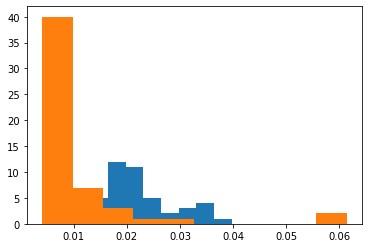

In [39]:
plt.hist(pre_post_pac[pre_post_pac['freq'] == 'low_gamma']['pac_pre'])
plt.hist(pre_post_pac[pre_post_pac['freq'] == 'low_gamma']['pac_post'])

(array([ 5., 18., 15.,  2.,  8.,  2.,  1.,  1.,  0.,  2.]),
 array([-2.39183376, -2.27385803, -2.15588229, -2.03790656, -1.91993082,
        -1.80195508, -1.68397935, -1.56600361, -1.44802788, -1.33005214,
        -1.2120764 ]),
 <BarContainer object of 10 artists>)

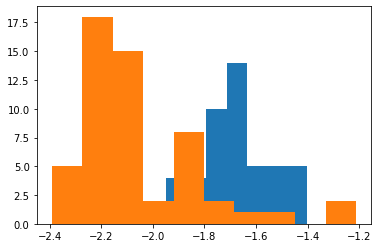

In [40]:
plt.hist(np.log10(pre_post_pac[pre_post_pac['freq'] == 'low_gamma']['pac_pre']))
plt.hist(np.log10(pre_post_pac[pre_post_pac['freq'] == 'low_gamma']['pac_post']))

(array([47.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([0.00414837, 0.01107859, 0.01800882, 0.02493904, 0.03186927,
        0.03879949, 0.04572972, 0.05265994, 0.05959016, 0.06652039,
        0.07345061]),
 <BarContainer object of 10 artists>)

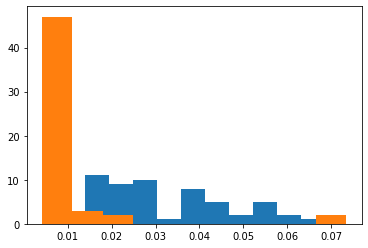

In [41]:
plt.hist(pre_post_pac[pre_post_pac['freq'] == 'high_gamma']['pac_pre'])
plt.hist(pre_post_pac[pre_post_pac['freq'] == 'high_gamma']['pac_post'])

(array([ 7., 23., 11.,  7.,  2.,  2.,  0.,  0.,  0.,  2.]),
 array([-2.38212258, -2.25731078, -2.13249898, -2.00768718, -1.88287538,
        -1.75806358, -1.63325178, -1.50843998, -1.38362818, -1.25881638,
        -1.13400458]),
 <BarContainer object of 10 artists>)

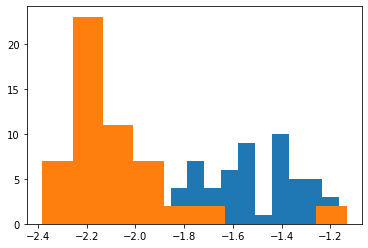

In [42]:
plt.hist(np.log10(pre_post_pac[pre_post_pac['freq'] == 'high_gamma']['pac_pre']))
plt.hist(np.log10(pre_post_pac[pre_post_pac['freq'] == 'high_gamma']['pac_post']))

In [43]:
from scipy.stats import ttest_rel

ttest_rel(pre_post_pac[pre_post_pac['freq'] == 'high_gamma']['pac_post'], pre_post_pac[pre_post_pac['freq'] == 'high_gamma']['pac_pre'])

Ttest_relResult(statistic=-7.73299460336168, pvalue=2.9923544738069313e-10)

In [44]:
from scipy.stats import ttest_rel

ttest_rel(np.log10(pre_post_pac[pre_post_pac['freq'] == 'high_gamma']['pac_post']), np.log10(pre_post_pac[pre_post_pac['freq'] == 'high_gamma']['pac_pre']))

Ttest_relResult(statistic=-12.042310556697581, pvalue=8.575014070494823e-17)

In [45]:
from scipy.stats import ttest_rel

ttest_rel(pre_post_pac[pre_post_pac['freq'] == 'low_gamma']['pac_post'], pre_post_pac[pre_post_pac['freq'] == 'low_gamma']['pac_pre'])

Ttest_relResult(statistic=-5.119100876402638, pvalue=4.3603247138885636e-06)

In [46]:
from scipy.stats import ttest_rel

ttest_rel(np.log10(pre_post_pac[pre_post_pac['freq'] == 'low_gamma']['pac_post']), np.log10(pre_post_pac[pre_post_pac['freq'] == 'low_gamma']['pac_pre']))

Ttest_relResult(statistic=-7.426765228577269, pvalue=9.280422488441598e-10)

(array([ 8., 13., 19.,  9.,  3.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.02897671, -0.02083586, -0.01269502, -0.00455417,  0.00358668,
         0.01172753,  0.01986837,  0.02800922,  0.03615007,  0.04429092,
         0.05243176]),
 <BarContainer object of 10 artists>)

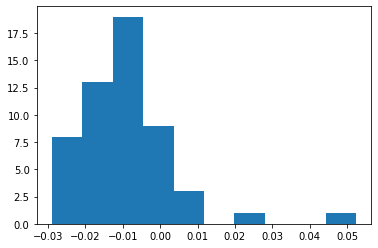

In [47]:
from scipy.stats import ttest_rel

plt.hist(pre_post_pac[pre_post_pac['freq'] == 'low_gamma']['pac_post'] - pre_post_pac[pre_post_pac['freq'] == 'low_gamma']['pac_pre'])

(array([ 3.,  7., 12., 15., 12.,  3.,  0.,  0.,  0.,  2.]),
 array([-0.06273271, -0.05085949, -0.03898627, -0.02711305, -0.01523983,
        -0.00336661,  0.00850661,  0.02037983,  0.03225305,  0.04412627,
         0.05599949]),
 <BarContainer object of 10 artists>)

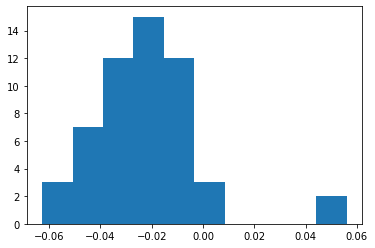

In [48]:
plt.hist(pre_post_pac[pre_post_pac['freq'] == 'high_gamma']['pac_post'] - pre_post_pac[pre_post_pac['freq'] == 'high_gamma']['pac_pre'])

conclusions: stim decreases PAC, particularly in high-gamma. Also decreases low-gamma, but not significant

In [49]:
post_pac = pd.read_csv('./post_pac_and_mem_max.csv')

In [50]:
pre_pac = pre_pac.drop('Unnamed: 0', axis=1)
post_pac = post_pac.drop('Unnamed: 0', axis=1)

In [51]:
post_pac

pt_num           chan  trial        freq       pac  Avg_Sham  \
0       105  RHip1 - RHip2      1       alpha  0.008191  6.666667   
1       105  RHip1 - RHip2      1        beta  0.010995  6.666667   
2       105  RHip1 - RHip2      1   low_gamma  0.022375  6.666667   
3       105  RHip1 - RHip2      1  high_gamma  0.014484  6.666667   
4       105  RHip1 - RHip2      2       alpha  0.017091  6.666667   
..      ...            ...    ...         ...       ...       ...   
235     115  RHip3 - RHip4      2  high_gamma  0.014345  5.000000   
236     115  RHip3 - RHip4      3       alpha  0.009227  5.000000   
237     115  RHip3 - RHip4      3        beta  0.020827  5.000000   
238     115  RHip3 - RHip4      3   low_gamma  0.014631  5.000000   
239     115  RHip3 - RHip4      3  high_gamma  0.022951  5.000000   

     Memory_Score  Trial  
0               5      1  
1               5      1  
2               5      1  
3               5      1  
4               7      2  
..            ...    ...  
235             6      2  
236             5      3  
237             5      3  
238             5      3  
239             5      3  

[240 rows x 8 columns]

In [52]:
post_pac = post_pac.rename({'pac': 'post_pac'}, axis=1)

In [53]:
post_pac['pre_pac'] = pre_pac['pac']

In [54]:
pac_and_mem = post_pac

In [55]:
pac_and_mem

pt_num           chan  trial        freq  post_pac  Avg_Sham  \
0       105  RHip1 - RHip2      1       alpha  0.008191  6.666667   
1       105  RHip1 - RHip2      1        beta  0.010995  6.666667   
2       105  RHip1 - RHip2      1   low_gamma  0.022375  6.666667   
3       105  RHip1 - RHip2      1  high_gamma  0.014484  6.666667   
4       105  RHip1 - RHip2      2       alpha  0.017091  6.666667   
..      ...            ...    ...         ...       ...       ...   
235     115  RHip3 - RHip4      2  high_gamma  0.014345  5.000000   
236     115  RHip3 - RHip4      3       alpha  0.009227  5.000000   
237     115  RHip3 - RHip4      3        beta  0.020827  5.000000   
238     115  RHip3 - RHip4      3   low_gamma  0.014631  5.000000   
239     115  RHip3 - RHip4      3  high_gamma  0.022951  5.000000   

     Memory_Score  Trial   pre_pac  
0               5      1  0.042619  
1               5      1  0.030845  
2               5      1  0.022667  
3               5      1  0.023378  
4               7      2  0.055642  
..            ...    ...       ...  
235             6      2  0.055819  
236             5      3  0.031355  
237             5      3  0.018690  
238             5      3  0.013584  
239             5      3  0.036809  

[240 rows x 9 columns]

In [56]:
pac_and_mem['chg_pac'] = pac_and_mem['post_pac'] - pac_and_mem['pre_pac']

In [57]:
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

In [58]:
from scipy.stats import kendalltau, linregress
for hip_ch in hip_chans:
    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == hip_ch)]
    print(linregress(df_filtered['post_pac'] - df_filtered['pre_pac'], df_filtered['Memory_Score']))

LinregressResult(slope=31.49531227405588, intercept=6.7200228528079675, rvalue=0.21121919332034114, pvalue=0.5853857258243518, stderr=55.08749934380586, intercept_stderr=0.7757102445291599)
LinregressResult(slope=-24.387826536801015, intercept=6.769877193191657, rvalue=-0.37894756475534813, pvalue=0.3145298888119225, stderr=22.510387311419937, intercept_stderr=0.7101676095641101)
LinregressResult(slope=-7.730828409978717, intercept=6.518343271553864, rvalue=-0.07275653173664441, pvalue=0.8222084500938056, stderr=33.512090547287556, intercept_stderr=0.5594853847989467)
LinregressResult(slope=20.393515466534964, intercept=6.517831377130732, rvalue=0.13409338582647504, pvalue=0.6777891653306216, stderr=47.658972738176836, intercept_stderr=0.5518384556238579)


In [59]:
from scipy.stats import kendalltau, linregress
for hip_ch in hip_chans:
    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'high_gamma') & (pac_and_mem['chan'] == hip_ch)]
    print(linregress(df_filtered['post_pac'] - df_filtered['pre_pac'], df_filtered['Memory_Score']))

LinregressResult(slope=70.58394116071759, intercept=8.295088733170324, rvalue=0.3138917070774193, pvalue=0.4107482735331188, stderr=80.69621451734102, intercept_stderr=2.1082720602993823)
LinregressResult(slope=-13.646684452063912, intercept=6.358676398397286, rvalue=-0.1717833445748151, pvalue=0.658537782900972, stderr=29.5796285414862, intercept_stderr=0.8421927820933357)
LinregressResult(slope=57.52379257813654, intercept=7.343174956280933, rvalue=0.5382745574231781, pvalue=0.07101135439531325, stderr=28.480820108399325, intercept_stderr=0.6271172990011696)
LinregressResult(slope=0.005605777716029271, intercept=6.500075762716485, rvalue=3.994684526553272e-05, pvalue=0.9999016933106886, stderr=44.376534635691286, intercept_stderr=0.8173359303299425)


In [60]:
from scipy.stats import kendalltau, linregress
for hip_ch in hip_chans:
    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == hip_ch)]
    print(kendalltau(df_filtered['post_pac'] - df_filtered['pre_pac'], df_filtered['Memory_Score']))

KendalltauResult(correlation=-0.029012942659282972, pvalue=0.9152657584373534)
KendalltauResult(correlation=-0.26111648393354675, pvalue=0.3382688788696867)
KendalltauResult(correlation=-0.016303866268150613, pvalue=0.943674862164647)
KendalltauResult(correlation=0.048911598804451846, pvalue=0.8321417682696266)


In [61]:
from scipy.stats import kendalltau, linregress
for hip_ch in hip_chans:
    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'high_gamma') & (pac_and_mem['chan'] == hip_ch)]
    print(kendalltau(df_filtered['post_pac'] - df_filtered['pre_pac'], df_filtered['Memory_Score']))

KendalltauResult(correlation=0.3191423692521127, pvalue=0.24184430404946322)
KendalltauResult(correlation=-0.14506471329641488, pvalue=0.5947293361935915)
KendalltauResult(correlation=0.4402043892400666, pvalue=0.05644302505692858)
KendalltauResult(correlation=-0.048911598804451846, pvalue=0.8321417682696266)


here's one of the most promising results from pre-stim

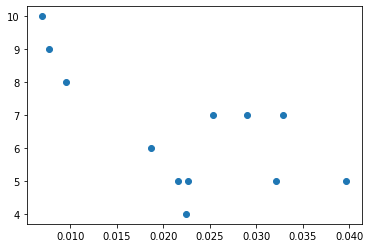

In [62]:
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'RHip1 - RHip2')]
plt.scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'])

so let's see how it does with post-minus-pre-stim

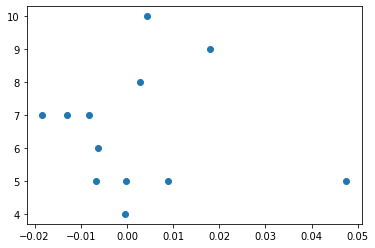

In [63]:
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'RHip1 - RHip2')]
plt.scatter(df_filtered['post_pac'] - df_filtered['pre_pac'], df_filtered['Memory_Score'])

fairly positive. I'm willing to look at the linear regression

In [64]:
linregress(df_filtered['post_pac'] - df_filtered['pre_pac'], df_filtered['Memory_Score'])

LinregressResult(slope=-7.730828409978717, intercept=6.518343271553864, rvalue=-0.07275653173664441, pvalue=0.8222084500938056, stderr=33.512090547287556, intercept_stderr=0.5594853847989467)

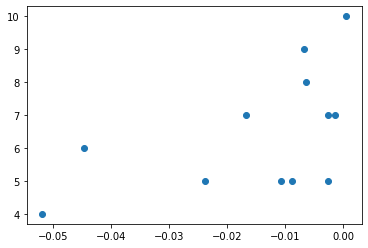

In [65]:
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'high_gamma') & (pac_and_mem['chan'] == 'RHip1 - RHip2')]
plt.scatter(df_filtered['post_pac'] - df_filtered['pre_pac'], df_filtered['Memory_Score'])

In [66]:
linregress(df_filtered['post_pac'] - df_filtered['pre_pac'], df_filtered['Memory_Score'])

LinregressResult(slope=57.52379257813654, intercept=7.343174956280933, rvalue=0.5382745574231781, pvalue=0.07101135439531325, stderr=28.480820108399325, intercept_stderr=0.6271172990011696)

Seems highly dependent on the 2 corner points to me. Bootstrapping one of them out could five me a more accurate p-value, but that's a lot of work so I'll try mixed-model first

In [67]:
from statsmodels.api import formula as smf

model = smf.mixedlm('Memory_Score ~ chg_pac', df_filtered, groups='pt_num')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: Memory_Score
No. Observations: 12      Method:             REML        
No. Groups:       4       Scale:              1.2698      
Min. group size:  3       Log-Likelihood:     -15.7704    
Max. group size:  3       Converged:          Yes         
Mean group size:  3.0                                     
----------------------------------------------------------
               Coef.  Std.Err.   z   P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept       7.074    0.935 7.564 0.000   5.241   8.907
chg_pac        39.168   36.711 1.067 0.286 -32.785 111.120
pt_num Var      1.917    2.134                            
==========================================================

"""

well, if the mixed model works, too, I might actually accept this result. Next, I want to see a scatter-plot, and if that looks good, I'll try to reproduce the heatmap I have for power and memory

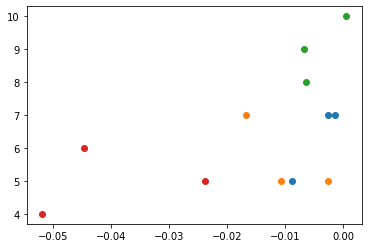

In [68]:
for pt_num in df_filtered['pt_num'].unique():
    plt.scatter(df_filtered[df_filtered['pt_num'] == pt_num]['chg_pac'], df_filtered[df_filtered['pt_num'] == pt_num]['Memory_Score'])

Well, all four patients *are* vaguely positive. I'll take it. Finally, let's try our heatmap

In [69]:
from scipy.stats import kendalltau, linregress
results = []
for hip_ch in hip_chans:
    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'alpha') & (pac_and_mem['chan'] == hip_ch)]
    alpha_p = linregress(df_filtered['pac'], df_filtered['Memory_Score']).pvalue

    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'beta') & (pac_and_mem['chan'] == hip_ch)]
    beta_p = linregress(df_filtered['pac'], df_filtered['Memory_Score']).pvalue

    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == hip_ch)]
    low_p = linregress(df_filtered['pac'], df_filtered['Memory_Score']).pvalue

    df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'high_gamma') & (pac_and_mem['chan'] == hip_ch)]
    high_p = linregress(df_filtered['pac'], df_filtered['Memory_Score']).pvalue
        
    results.append({
        'alpha': alpha_p,
        'beta': beta_p,
        'low': low_p,
        'high': high_p,
        'chan': hip_ch,
    })

KeyError: 'pac'

In [ ]:
df_stats = pd.DataFrame(results)

In [ ]:
df_stats = df_stats.set_index('chan')

In [ ]:
df_stats

alpha      beta       low      high
chan                                                 
LHip1 - LHip2  0.201877  0.818449  0.013353  0.339814
LHip3 - LHip4  0.452050  0.525066  0.979439  0.964946
RHip1 - RHip2  0.764240  0.754027  0.020125  0.019601
RHip3 - RHip4  0.196952  0.293214  0.115934  0.732128

In [ ]:
from stats_pipeline import fdr_bh

In [ ]:
fdr_bh(df_stats)

alpha      beta       low      high
Channel                                              
LHip1 - LHip2  0.538340  0.935370  0.107335  0.679628
LHip3 - LHip4  0.803645  0.840106  0.979439  0.979439
RHip1 - RHip2  0.935370  0.935370  0.107335  0.107335
RHip3 - RHip4  0.538340  0.670203  0.463736  0.935370

<AxesSubplot:xlabel='chan'>

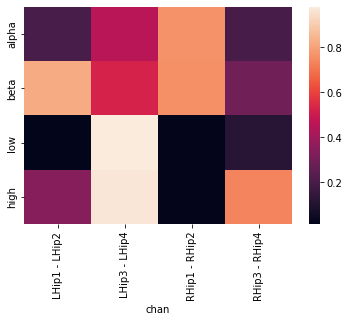

In [ ]:
import seaborn as sns
sns.heatmap(df_stats.T)

This is more or less one of the figures that I want to use for the final paper. However, I will change to using the t-values rather than the p-values for the final graph. Let me try that below.

### Pre-Stim PAC vs Trial Mem

In [ ]:
pac_and_mem = pd.read_csv('pre_pac_and_mem2.csv')

<AxesSubplot:xlabel='chan'>

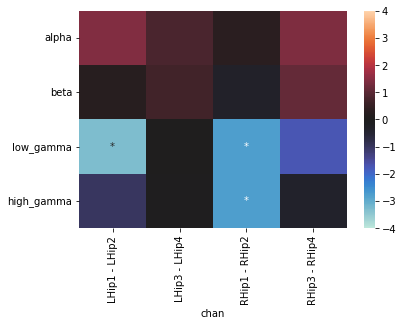

In [ ]:
from scipy.stats import kendalltau, linregress
pvals = []
tvals = []
for hip_ch in hip_chans:
    pvals_for_chan = {'chan': hip_ch}
    tvals_for_chan = {'chan': hip_ch}
    for freq in ['alpha', 'beta', 'low_gamma', 'high_gamma']:
        df_filtered = pac_and_mem[(pac_and_mem['freq'] == freq) & (pac_and_mem['chan'] == hip_ch)]
        results = linregress(df_filtered['pac'], df_filtered['Memory_Score'])
        pvals_for_chan[freq] = results.pvalue
        tvals_for_chan[freq] = results.slope / results.stderr
        
    pvals.append(pvals_for_chan)
    tvals.append(tvals_for_chan)

pvals = pd.DataFrame(pvals)
pvals = pvals.set_index('chan')
tvals = pd.DataFrame(tvals)
tvals = tvals.set_index('chan')

p_stars = np.where(pvals.T < 0.05, '*', '')
sns.heatmap(tvals.T, center=0, annot=p_stars, fmt='', vmin=-4, vmax=4)

<AxesSubplot:xlabel='chan'>

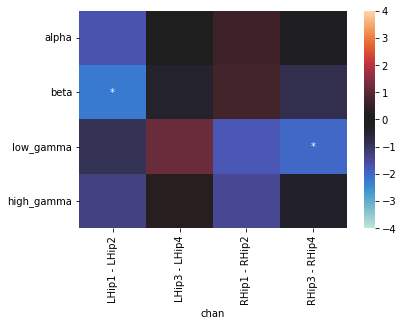

In [ ]:
from scipy.stats import kendalltau, linregress
from statsmodels.api import formula as smf

pvals = []
tvals = []
for hip_ch in hip_chans:
    pvals_for_chan = {'chan': hip_ch}
    tvals_for_chan = {'chan': hip_ch}
    for freq in ['alpha', 'beta', 'low_gamma', 'high_gamma']:
        df_filtered = pac_and_mem[(pac_and_mem['freq'] == freq) & (pac_and_mem['chan'] == hip_ch)]
        model = smf.mixedlm('Memory_Score ~ pac', df_filtered, groups='pt_num')
        results = model.fit()
        pvals_for_chan[freq] = results.pvalues['pac']
        tvals_for_chan[freq] = results.tvalues['pac']
        
    pvals.append(pvals_for_chan)
    tvals.append(tvals_for_chan)

pvals = pd.DataFrame(pvals)
pvals = pvals.set_index('chan')
tvals = pd.DataFrame(tvals)
tvals = tvals.set_index('chan')

p_stars = np.where(pvals.T < 0.05, '*', '')
sns.heatmap(tvals.T, center=0, annot=p_stars, fmt='', vmin=-4, vmax=4)

### Post-Stim PAC vs Trial Mem

In [ ]:
pac_and_mem = pd.read_csv('post_pac_and_mem2.csv')

<AxesSubplot:xlabel='chan'>

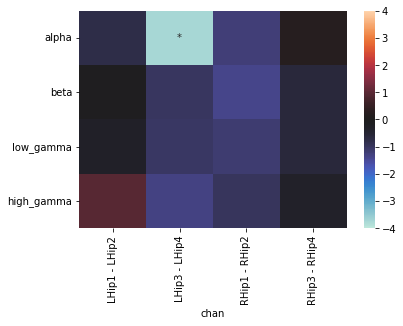

In [ ]:
from scipy.stats import kendalltau, linregress
pvals = []
tvals = []
for hip_ch in hip_chans:
    pvals_for_chan = {'chan': hip_ch}
    tvals_for_chan = {'chan': hip_ch}
    for freq in ['alpha', 'beta', 'low_gamma', 'high_gamma']:
        df_filtered = pac_and_mem[(pac_and_mem['freq'] == freq) & (pac_and_mem['chan'] == hip_ch)]
        results = linregress(df_filtered['pac'], df_filtered['Memory_Score'])
        pvals_for_chan[freq] = results.pvalue
        tvals_for_chan[freq] = results.slope / results.stderr
        
    pvals.append(pvals_for_chan)
    tvals.append(tvals_for_chan)

pvals = pd.DataFrame(pvals)
pvals = pvals.set_index('chan')
tvals = pd.DataFrame(tvals)
tvals = tvals.set_index('chan')

p_stars = np.where(pvals.T < 0.05, '*', '')
sns.heatmap(tvals.T, center=0, annot=p_stars, fmt='', vmin=-4, vmax=4)

<AxesSubplot:xlabel='chan'>

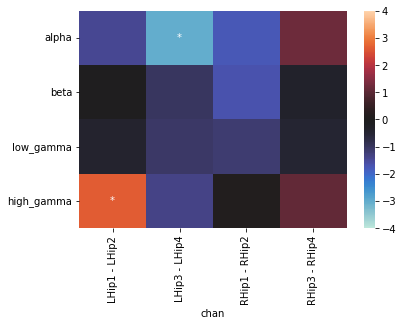

In [ ]:
from scipy.stats import kendalltau, linregress
from statsmodels.api import formula as smf

pvals = []
tvals = []
for hip_ch in hip_chans:
    pvals_for_chan = {'chan': hip_ch}
    tvals_for_chan = {'chan': hip_ch}
    for freq in ['alpha', 'beta', 'low_gamma', 'high_gamma']:
        df_filtered = pac_and_mem[(pac_and_mem['freq'] == freq) & (pac_and_mem['chan'] == hip_ch)]
        model = smf.mixedlm('Memory_Score ~ pac', df_filtered, groups='pt_num')
        results = model.fit()
        pvals_for_chan[freq] = results.pvalues['pac']
        tvals_for_chan[freq] = results.tvalues['pac']
        
    pvals.append(pvals_for_chan)
    tvals.append(tvals_for_chan)

pvals = pd.DataFrame(pvals)
pvals = pvals.set_index('chan')
tvals = pd.DataFrame(tvals)
tvals = tvals.set_index('chan')

p_stars = np.where(pvals.T < 0.05, '*', '')
sns.heatmap(tvals.T, center=0, annot=p_stars, fmt='', vmin=-4, vmax=4)

### Change in PAC vs Trial Memory

In [ ]:
post_pac_mem = pd.read_csv('post_pac_and_mem_max.csv')
pre_pac_mem = pd.read_csv('pre_pac_and_mem_max.csv')
len(post_pac_mem), len(pre_pac_mem)

(240, 240)

In [ ]:
pac_and_mem = post_pac_mem.rename({'pac': 'post_pac'}, axis=1)
pac_and_mem['pre_pac'] = pre_pac_mem['pac']
pac_and_mem = pac_and_mem.drop('Unnamed: 0', axis=1)
pac_and_mem['chg_pac'] = pac_and_mem['post_pac'] - pac_and_mem['pre_pac']

c:\Users\seand\eeg_proj\venv\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\seand\eeg_proj\venv\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='chan'>

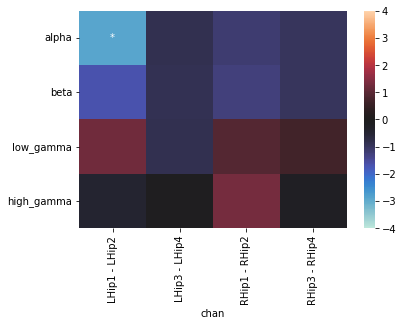

In [ ]:
from scipy.stats import kendalltau, linregress
import seaborn as sns
pvals = []
tvals = []
for hip_ch in hip_chans:
    pvals_for_chan = {'chan': hip_ch}
    tvals_for_chan = {'chan': hip_ch}
    for freq in ['alpha', 'beta', 'low_gamma', 'high_gamma']:
        df_filtered = pac_and_mem[(pac_and_mem['freq'] == freq) & (pac_and_mem['chan'] == hip_ch)]
        results = linregress(df_filtered['chg_pac'], df_filtered['Memory_Score'])
        pvals_for_chan[freq] = results.pvalue
        tvals_for_chan[freq] = results.slope / results.stderr
        
    pvals.append(pvals_for_chan)
    tvals.append(tvals_for_chan)

pvals = pd.DataFrame(pvals)
pvals = pvals.set_index('chan')
tvals = pd.DataFrame(tvals)
tvals = tvals.set_index('chan')

p_stars = np.where(pvals.T < 0.05, '*', '')
sns.heatmap(tvals.T, center=0, annot=p_stars, fmt='', vmin=-4, vmax=4)

<AxesSubplot:xlabel='chan'>

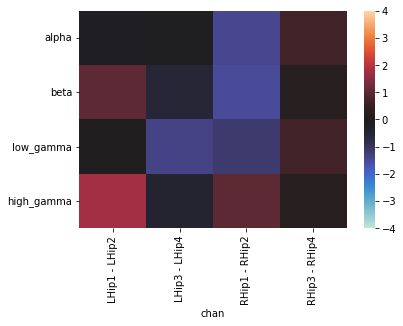

In [ ]:
from scipy.stats import kendalltau, linregress
from statsmodels.api import formula as smf

pvals = []
tvals = []
for hip_ch in hip_chans:
    pvals_for_chan = {'chan': hip_ch}
    tvals_for_chan = {'chan': hip_ch}
    for freq in ['alpha', 'beta', 'low_gamma', 'high_gamma']:
        df_filtered = pac_and_mem[(pac_and_mem['freq'] == freq) & (pac_and_mem['chan'] == hip_ch)]
        model = smf.mixedlm('Memory_Score ~ chg_pac', df_filtered, groups='pt_num')
        results = model.fit()
        pvals_for_chan[freq] = results.pvalues['chg_pac']
        tvals_for_chan[freq] = results.tvalues['chg_pac']
        
    pvals.append(pvals_for_chan)
    tvals.append(tvals_for_chan)

pvals = pd.DataFrame(pvals)
pvals = pvals.set_index('chan')
tvals = pd.DataFrame(tvals)
tvals = tvals.set_index('chan')

p_stars = np.where(pvals.T < 0.05, '*', '')
sns.heatmap(tvals.T, center=0, annot=p_stars, fmt='', vmin=-4, vmax=4)

In [ ]:
pac_and_mem.to_csv('chg_pac_and_mem_max.csv', index=False)

# More organized

In [71]:
pac_and_mem = pd.read_csv('chg_pac_and_mem2.csv')

In [72]:
pac_and_mem.loc[pac_and_mem['pt_num'] == 113, 'chan'] = pac_and_mem[pac_and_mem['pt_num'] == 113]['chan'].apply(lambda s: s.replace('H', 'Hip'))

In [114]:
from scipy.stats import kendalltau, linregress
from statsmodels.api import formula as smf
from statsmodels.stats.multitest import fdrcorrection
from stats_pipeline import fdr_bh
import seaborn as sns

hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
def draw_heatmap(x, method: Literal['linreg', 'mixed'], ax):
    pvals = []
    tvals = []
    for hip_ch in hip_chans:
        pvals_for_chan = {'chan': hip_ch}
        tvals_for_chan = {'chan': hip_ch}
        for freq in ['low_gamma', 'high_gamma']:
            df_filtered = pac_and_mem[(pac_and_mem['freq'] == freq) & (pac_and_mem['chan'] == hip_ch)]
            if method == 'linreg':
                results = linregress(df_filtered[x], df_filtered['Memory_Score'])
                pvals_for_chan[freq] = results.pvalue
                tvals_for_chan[freq] = results.slope / results.stderr
            elif method == 'mixed':
                model = smf.mixedlm('Memory_Score ~ '+x, df_filtered, groups='pt_num')
                results = model.fit()
                pvals_for_chan[freq] = results.pvalues[x]
                tvals_for_chan[freq] = results.tvalues[x]
            else:
                raise Exception('unsupported method: ' + method)

            if pvals_for_chan[freq] < 0.05:
                print(f"{hip_ch} {freq}: t = {tvals_for_chan[freq]}, p = {pvals_for_chan[freq]}")
            
        pvals.append(pvals_for_chan)
        tvals.append(tvals_for_chan)

    pvals = pd.DataFrame(pvals)
    pvals = pvals.set_index('chan')
    # print(pvals)
    # pvals = fdr_bh(pvals)
    # pvals = pvals.apply(lambda grp: fdrcorrection(grp)[1], axis=1)
    # print(pvals)
    tvals = pd.DataFrame(tvals)
    tvals = tvals.set_index('chan')

    p_stars = np.where(fdr_bh(pvals.T) < 0.05, '*', '')

    # p_within_ea_col = pvals.apply(lambda x: fdrcorrection(x)[1], axis=0)
    # p_within_ea_row = pvals.T.apply(lambda x: fdrcorrection(x)[1], axis=0).T
    # p_stars = np.where(p_within_ea_col < 0.05, '*', '')
    # p_stars = np.where(p_within_ea_row < 0.05, '†', p_stars)
    # p_stars = np.where((p_within_ea_col < 0.05) & (p_within_ea_row < 0.05), '*†', p_stars)

    sns.heatmap(tvals.T, center=0, annot=p_stars, fmt='', vmin=-4, vmax=4, ax=ax, 
        xticklabels=['Left\nAnterior', 'Left\nPosterior', 'Right\nAnterior', 'Right\nPosterior'], 
        yticklabels=['Low Gamma', 'High Gamma'])

In [106]:
pvals = []
tvals = []
for hip_ch in hip_chans:
    pvals_for_chan = {'chan': hip_ch}
    tvals_for_chan = {'chan': hip_ch}
    for freq in ['alpha', 'beta', 'low_gamma', 'high_gamma']:
        df_filtered = pac_and_mem[(pac_and_mem['freq'] == freq) & (pac_and_mem['chan'] == hip_ch)]
        results = linregress(df_filtered['chg_pac'], df_filtered['Memory_Score'])
        pvals_for_chan[freq] = results.pvalue
    pvals.append(pvals_for_chan)
pvals = pd.DataFrame(pvals)
pvals = pvals.set_index('chan')

In [75]:
fdr_bh(pvals)

alpha      beta  low_gamma  high_gamma
Channel                                                 
LHip1 - LHip2  0.980084  0.788617   0.207001    0.339597
LHip3 - LHip4  0.788617  0.788617   0.788617    0.788617
RHip1 - RHip2  0.788617  0.788617   0.788617    0.306947
RHip3 - RHip4  0.788617  0.788617   0.339597    0.788617

In [76]:
df_for_crosstab = pac_and_mem.copy()
df_for_crosstab['chg_mem'] = df_for_crosstab['Memory_Score'] - df_for_crosstab['Avg_Sham']

In [77]:
df_filtered = df_for_crosstab[(df_for_crosstab['freq'] == 'low_gamma') & (df_for_crosstab['chan'] == 'LHip1 - LHip2')]
pd.crosstab(df_filtered['chg_pac'] > 0, df_filtered['chg_mem'] > 0)

chg_mem  False  True
chg_pac             
False        6     6

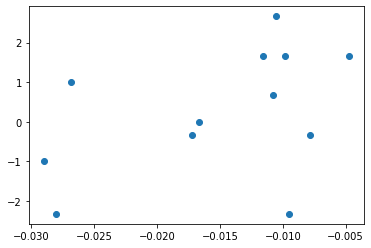

In [78]:
plt.scatter(df_filtered['chg_pac'], df_filtered['chg_mem'])

In [79]:
pac_and_mem

pt_num           chan  trial        freq  post_pac  Avg_Sham  \
0       105  RHip1 - RHip2      1       alpha  0.004103  6.666667   
1       105  RHip1 - RHip2      1        beta  0.004110  6.666667   
2       105  RHip1 - RHip2      1   low_gamma  0.007573  6.666667   
3       105  RHip1 - RHip2      1  high_gamma  0.005247  6.666667   
4       105  RHip1 - RHip2      2       alpha  0.007048  6.666667   
..      ...            ...    ...         ...       ...       ...   
235     115  RHip3 - RHip4      2  high_gamma  0.007466  5.000000   
236     115  RHip3 - RHip4      3       alpha  0.005241  5.000000   
237     115  RHip3 - RHip4      3        beta  0.007218  5.000000   
238     115  RHip3 - RHip4      3   low_gamma  0.007500  5.000000   
239     115  RHip3 - RHip4      3  high_gamma  0.006239  5.000000   

     Memory_Score  Trial   pre_pac   chg_pac  
0               5      1  0.042619 -0.038516  
1               5      1  0.030845 -0.026734  
2               5      1  0.022667 -0.015095  
3               5      1  0.023378 -0.018130  
4               7      2  0.055642 -0.048594  
..            ...    ...       ...       ...  
235             6      2  0.055819 -0.048353  
236             5      3  0.031355 -0.026115  
237             5      3  0.018690 -0.011472  
238             5      3  0.013584 -0.006084  
239             5      3  0.036809 -0.030570  

[240 rows x 10 columns]

pre_pac linreg
LHip1 - LHip2 low_gamma: t = -4.316165656771236, p = 0.0015222593457587402
RHip1 - RHip2 low_gamma: t = -2.56199601662058, p = 0.023649550117407485
RHip1 - RHip2 high_gamma: t = -3.374927308140743, p = 0.004976419182209967
RHip3 - RHip4 low_gamma: t = -2.6561749873309055, p = 0.019778018068469475
chg_pac linreg
LHip1 - LHip2 low_gamma: t = 3.018092358471066, p = 0.012937544170653582
RHip1 - RHip2 high_gamma: t = 2.304064396692939, p = 0.038368336897774316
post_pac linreg


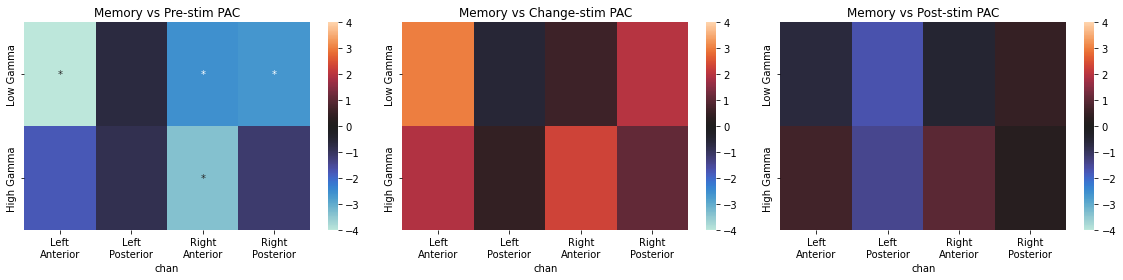

In [115]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(16,4)
methods = ['linreg']
xs = ['pre_pac', 'chg_pac', 'post_pac']
xs_titles = ['Pre', 'Change', 'Post']
for i in range(3):
    for j in range(1):
        axs[i].set_title('Memory vs '+xs_titles[i]+'-stim PAC')
        print(xs[i], methods[j])
        draw_heatmap(xs[i], methods[j], axs[i])
fig.tight_layout()

In [81]:
from matplotlib import cm

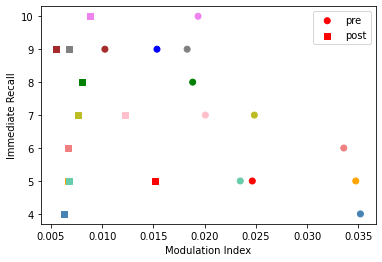

In [82]:
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'LHip1 - LHip2')]
colors = ['red', 'orange', 'tab:olive', 'green', 'blue', 'violet', 'pink', 'brown', 'gray', 'steelblue', 'lightcoral', 'mediumaquamarine']
plt.scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'], c=colors)
plt.scatter(df_filtered['post_pac'], df_filtered['Memory_Score'], c=colors, marker='s')
plt.xlabel('Modulation Index')
plt.ylabel('Immediate Recall')
plt.legend(['pre', 'post'])
# plt.scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'])

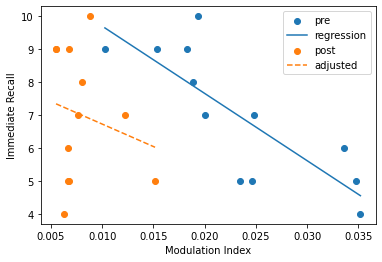

In [83]:
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'LHip1 - LHip2')]
# colors = ['red', 'orange', 'tab:olive', 'green', 'blue', 'violet', 'pink', 'brown', 'gray', 'steelblue', 'lightcoral', 'mediumaquamarine']
plt.scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'])
xs = np.array([df_filtered['pre_pac'].min(), df_filtered['pre_pac'].max()])
results = linregress(df_filtered['pre_pac'], df_filtered['Memory_Score'])
plt.plot(xs, results.intercept + results.slope * xs)
plt.scatter(df_filtered['post_pac'], df_filtered['Memory_Score'])
# results = linregress(df_filtered.drop([50, 146])['post_pac'], df_filtered.drop([50, 146])['Memory_Score'])
# xs = np.array([df_filtered.drop([50, 146])['post_pac'].min(), df_filtered.drop([50, 146])['post_pac'].max()])
results = linregress(df_filtered['post_pac'], df_filtered['Memory_Score'])
xs = np.array([df_filtered['post_pac'].min(), df_filtered['post_pac'].max()])
plt.plot(xs, results.intercept + results.slope * xs, ls='--')
plt.xlabel('Modulation Index')
plt.ylabel('Immediate Recall')
plt.legend(['pre', 'regression', 'post', 'adjusted'])
# plt.scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'])

In [84]:
chg_norm = (df_filtered['chg_pac'] - df_filtered['chg_pac'].min() + 0.001) / (df_filtered['chg_pac'].max() - df_filtered['chg_pac'].min())

(array([3., 0., 0., 0., 1., 1., 0., 4., 2., 1.]),
 array([0.97143909, 0.97381933, 0.97619958, 0.97857983, 0.98096007,
        0.98334032, 0.98572057, 0.98810081, 0.99048106, 0.99286131,
        0.99524155]),
 <BarContainer object of 10 artists>)

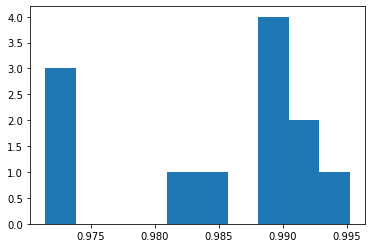

In [85]:
plt.hist(np.exp(df_filtered['chg_pac']))

(array([3., 0., 0., 0., 1., 1., 0., 4., 2., 1.]),
 array([-1.63689232, -1.34883702, -1.06078172, -0.77272643, -0.48467113,
        -0.19661583,  0.09143947,  0.37949477,  0.66755006,  0.95560536,
         1.24366066]),
 <BarContainer object of 10 artists>)

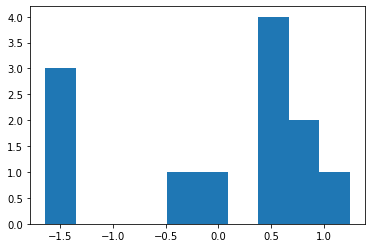

In [86]:
plt.hist((df_filtered['chg_pac'] - df_filtered['chg_pac'].mean()) / df_filtered['chg_pac'].std())

Text(0, 0.5, 'Immediate Recall')

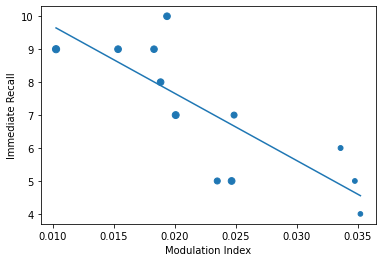

In [87]:
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'LHip1 - LHip2')]
# colors = ['red', 'orange', 'tab:olive', 'green', 'blue', 'violet', 'pink', 'brown', 'gray', 'steelblue', 'lightcoral', 'mediumaquamarine']
plt.scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'], s=20 + chg_norm * 30)
xs = np.array([df_filtered['pre_pac'].min(), df_filtered['pre_pac'].max()])
results = linregress(df_filtered['pre_pac'], df_filtered['Memory_Score'])
plt.plot(xs, results.intercept + results.slope * xs)
plt.xlabel('Modulation Index')
plt.ylabel('Immediate Recall')
# plt.legend([''])
# plt.scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'])

TODO

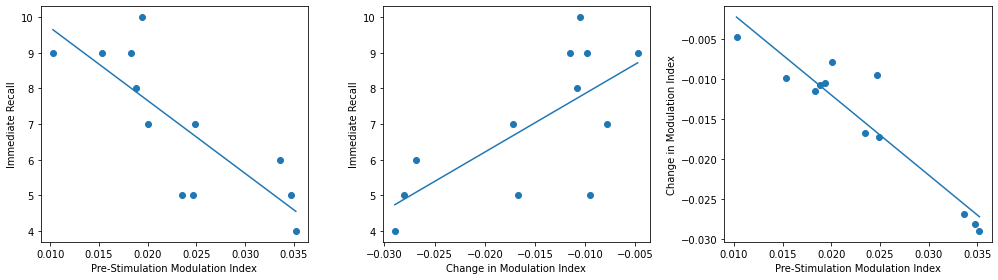

In [88]:
from scipy.stats import linregress

fig, axs = plt.subplots(1,3)
fig.set_size_inches(14, 4)
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'LHip1 - LHip2')]
# colors = ['red', 'orange', 'tab:olive', 'green', 'blue', 'violet', 'pink', 'brown', 'gray', 'steelblue', 'lightcoral', 'mediumaquamarine']
axs[0].scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'])
xs = np.array([df_filtered['pre_pac'].min(), df_filtered['pre_pac'].max()])
results = linregress(df_filtered['pre_pac'], df_filtered['Memory_Score'])
axs[0].plot(xs, results.intercept + results.slope * xs)
axs[0].set_xlabel('Pre-Stimulation Modulation Index')
axs[0].set_ylabel('Immediate Recall')

axs[1].scatter(df_filtered['chg_pac'], df_filtered['Memory_Score'])
xs = np.array([df_filtered['chg_pac'].min(), df_filtered['chg_pac'].max()])
results = linregress(df_filtered['chg_pac'], df_filtered['Memory_Score'])
axs[1].plot(xs, results.intercept + results.slope * xs)
axs[1].set_xlabel('Change in Modulation Index')
axs[1].set_ylabel('Immediate Recall')

axs[2].scatter(df_filtered['pre_pac'], df_filtered['chg_pac'])
xs = np.array([df_filtered['pre_pac'].min(), df_filtered['pre_pac'].max()])
results = linregress(df_filtered['pre_pac'], df_filtered['chg_pac'])
axs[2].plot(xs, results.intercept + results.slope * xs)
axs[2].set_xlabel('Pre-Stimulation Modulation Index')
axs[2].set_ylabel('Change in Modulation Index')
fig.tight_layout()

In [89]:
df_filtered['pt_num'].unique()

array([110, 112, 113, 115], dtype=int64)

Text(0, 0.5, 'Immediate Recall')

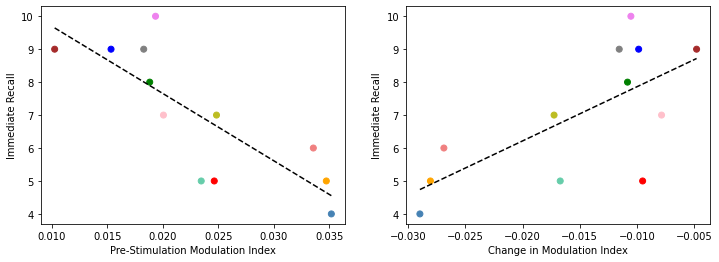

In [90]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12, 4)
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'LHip1 - LHip2')]
colors = ['red', 'orange', 'tab:olive', 'green', 'blue', 'violet', 'pink', 'brown', 'gray', 'steelblue', 'lightcoral', 'mediumaquamarine']
axs[0].scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'], c=colors)
xs = np.array([df_filtered['pre_pac'].min(), df_filtered['pre_pac'].max()])
results = linregress(df_filtered['pre_pac'], df_filtered['Memory_Score'])
axs[0].plot(xs, results.intercept + results.slope * xs, ls='--', c='black')
axs[0].set_xlabel('Pre-Stimulation Modulation Index')
axs[0].set_ylabel('Immediate Recall')

axs[1].scatter(df_filtered['chg_pac'], df_filtered['Memory_Score'], c=colors)
xs = np.array([df_filtered['chg_pac'].min(), df_filtered['chg_pac'].max()])
results = linregress(df_filtered['chg_pac'], df_filtered['Memory_Score'])
axs[1].plot(xs, results.intercept + results.slope * xs, ls='--', c='black')
axs[1].set_xlabel('Change in Modulation Index')
axs[1].set_ylabel('Immediate Recall')

In [91]:
markers = df_filtered['pt_num'].map({110: 'o', 112: '^', 113: 's', 115: 'x'})

Text(0, 0.5, 'Immediate Recall')

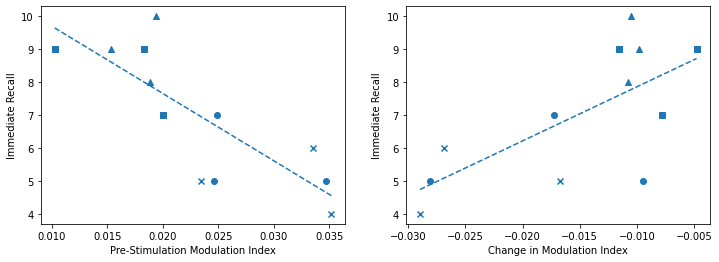

In [92]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12, 4)
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'LHip1 - LHip2')]
markers = ['o', '^', 's', 'x', '+']
for i, pt_num in enumerate(df_filtered['pt_num'].unique()):
    axs[0].scatter(
        df_filtered[df_filtered['pt_num'] == pt_num]['pre_pac'], 
        df_filtered[df_filtered['pt_num'] == pt_num]['Memory_Score'], 
        marker=markers[i], c='tab:blue')
xs = np.array([df_filtered['pre_pac'].min(), df_filtered['pre_pac'].max()])
results = linregress(df_filtered['pre_pac'], df_filtered['Memory_Score'])
axs[0].plot(xs, results.intercept + results.slope * xs, ls='--')
axs[0].set_xlabel('Pre-Stimulation Modulation Index')
axs[0].set_ylabel('Immediate Recall')

for i, pt_num in enumerate(df_filtered['pt_num'].unique()):
    axs[1].scatter(
        df_filtered[df_filtered['pt_num'] == pt_num]['chg_pac'], 
        df_filtered[df_filtered['pt_num'] == pt_num]['Memory_Score'], 
        marker=markers[i], c='tab:blue')
xs = np.array([df_filtered['chg_pac'].min(), df_filtered['chg_pac'].max()])
results = linregress(df_filtered['chg_pac'], df_filtered['Memory_Score'])
axs[1].plot(xs, results.intercept + results.slope * xs, ls='--')
axs[1].set_xlabel('Change in Modulation Index')
axs[1].set_ylabel('Immediate Recall')

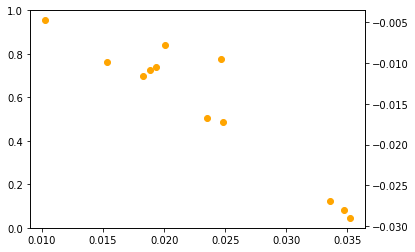

In [93]:
fig, ax = plt.subplots()

# ax.scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'])
ax2 = ax.twinx()
ax2.scatter(df_filtered['pre_pac'], df_filtered['chg_pac'], c='orange')

In [94]:
import statsmodels.formula.api as smf

formula = f"Memory_Score ~ pre_pac + chg_pac"
model = smf.ols(formula, df_filtered)
results = model.fit()
display(results.summary())

c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     9.943
Date:                Thu, 22 Dec 2022   Prob (F-statistic):            0.00526
Time:                        17:21:26   Log-Likelihood:                -17.826
No. Observations:                  12   AIC:                             41.65
Df Residuals:                       9   BIC:                             43.11
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.8110      1.540      8.318      0.000       9.327      16.295
pre_pac     -338.2403    136.759     -2.473      0.035    -647.611     -28.870
chg_pac     -134.2396    128.579     -1.044      0.324    -425.106     156.627
==============================================================================
Omnibus:                        1.329   Durbin-Watson:                   2.247
Prob(Omnibus):                  0.515   Jarque-Bera (JB):                0.118
Skew:                           0.182   Prob(JB):                        0.943
Kurtosis:                       3.319   Cond. No.                         519.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

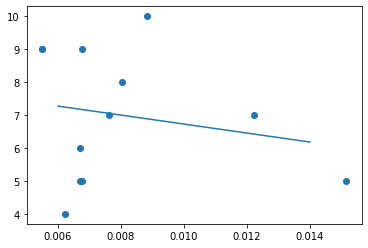

In [95]:
import statsmodels.api as sm
model = sm.RLM(df_filtered['Memory_Score'], sm.add_constant(df_filtered['post_pac']), M=sm.robust.norms.TrimmedMean())
results = model.fit()
plt.scatter(df_filtered['post_pac'], df_filtered['Memory_Score'])
x = np.array([0.006, 0.014])
plt.plot(x, results.params[0] + results.params[1] * x)

In [96]:
smf.quantreg("Memory_Score ~ post_pac", df_filtered).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:           Memory_Score   Pseudo R-squared:              0.04780
Model:                       QuantReg   Bandwidth:                       5.496
Method:                 Least Squares   Sparsity:                        8.796
Date:                Thu, 22 Dec 2022   No. Observations:                   12
Time:                        17:21:27   Df Residuals:                       10
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2746      3.879      2.906      0.016       2.631      19.918
post_pac    -413.9430    458.211     -0.903      0.388   -1434.901     607.015
==============================================================================
"""

AttributeError: module 'statsmodels.formula.api' has no attribute 'RLM'

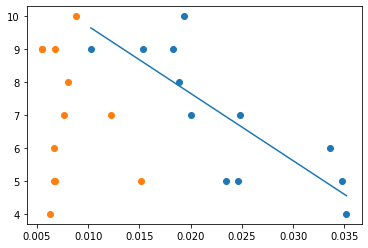

In [97]:

df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'low_gamma') & (pac_and_mem['chan'] == 'LHip1 - LHip2')]
# colors = ['red', 'orange', 'tab:olive', 'green', 'blue', 'violet', 'pink', 'brown', 'gray', 'steelblue', 'lightcoral', 'mediumaquamarine']
plt.scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'])
xs = np.array([df_filtered['pre_pac'].min(), df_filtered['pre_pac'].max()])
results = linregress(df_filtered['pre_pac'], df_filtered['Memory_Score'])
plt.plot(xs, results.intercept + results.slope * xs)

plt.scatter(df_filtered['post_pac'], df_filtered['Memory_Score'])

smf.RLM(df_filtered['Memory_Score'], df_filtered['post_pac'])
plt.plot(xs, results.intercept + results.slope * xs, ls='--')
plt.xlabel('Modulation Index')
plt.ylabel('Immediate Recall')
plt.legend(['pre', 'regression', 'post', 'adjusted'])
# plt.scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'])

In [ ]:
df_filtered = pac_and_mem[(pac_and_mem['freq'] == 'alpha') & (pac_and_mem['chan'] == 'LHip3 - LHip4')]
model = smf.mixedlm('Memory_Score ~ post_pac', df_filtered, groups='pt_num')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: Memory_Score
No. Observations: 12      Method:             REML        
No. Groups:       4       Scale:              1.1964      
Min. group size:  3       Log-Likelihood:     -14.4185    
Max. group size:  3       Converged:          Yes         
Mean group size:  3.0                                     
----------------------------------------------------------
            Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept     8.367    1.710  4.894 0.000    5.016  11.717
post_pac   -200.828  207.907 -0.966 0.334 -608.317 206.662
pt_num Var    3.285    3.256                              
==========================================================

"""

In [ ]:
df_filtered

pt_num           chan  trial   freq  post_pac  Avg_Sham  Memory_Score  \
60      110  LHip3 - LHip4      1  alpha  0.008462  7.333333             5   
64      110  LHip3 - LHip4      2  alpha  0.008549  7.333333             5   
68      110  LHip3 - LHip4      3  alpha  0.005289  7.333333             7   
108     112  LHip3 - LHip4      1  alpha  0.004959  7.333333             8   
112     112  LHip3 - LHip4      2  alpha  0.003779  7.333333             9   
116     112  LHip3 - LHip4      3  alpha  0.004581  7.333333            10   
156     113  LHip3 - LHip4      1  alpha  0.006531  7.333333             7   
160     113  LHip3 - LHip4      2  alpha  0.009276  7.333333             9   
164     113  LHip3 - LHip4      3  alpha  0.009915  7.333333             9   
204     115  LHip3 - LHip4      1  alpha  0.009451  5.000000             4   
208     115  LHip3 - LHip4      2  alpha  0.005466  5.000000             6   
212     115  LHip3 - LHip4      3  alpha  0.005399  5.000000             5   

     Trial   pre_pac   chg_pac  
60       1  0.011665 -0.003203  
64       2  0.014988 -0.006439  
68       3  0.015549 -0.010260  
108      1  0.039237 -0.034278  
112      2  0.053574 -0.049795  
116      3  0.023692 -0.019111  
156      1  0.056848 -0.050317  
160      2  0.023727 -0.014452  
164      3  0.016048 -0.006133  
204      1  0.027641 -0.018191  
208      2  0.032535 -0.027069  
212      3  0.048028 -0.042629

What is the effect of stim?

(array([173.,  47.,   7.,   3.,   2.,   3.,   0.,   1.,   2.,   2.]),
 array([0.00138922, 0.00859536, 0.01580149, 0.02300763, 0.03021377,
        0.03741991, 0.04462605, 0.05183219, 0.05903833, 0.06624447,
        0.07345061]),
 <BarContainer object of 10 artists>)

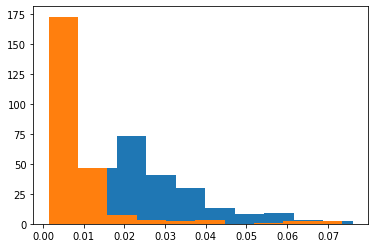

In [ ]:
plt.hist(pac_and_mem['pre_pac'])
plt.hist(pac_and_mem['post_pac'])

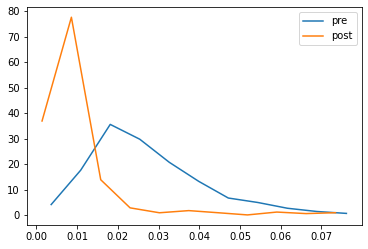

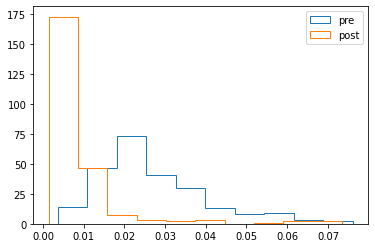

In [ ]:
from scipy.stats import gaussian_kde
fig, ax = plt.subplots()
fig_, ax_ = plt.subplots()
density = gaussian_kde(pac_and_mem['pre_pac'])
n, x, _ = ax_.hist(pac_and_mem['pre_pac'], histtype='step')
ax.plot(x, density(x))
density = gaussian_kde(pac_and_mem['post_pac'])
n, x, _ = ax_.hist(pac_and_mem['post_pac'], histtype='step')
ax.plot(x, density(x))
ax.legend(['pre', 'post'])
ax_.legend(['pre', 'post'])

TODO two histograms, one for high-memory, one for low-memory. probably better visualization than the scatter plot

<AxesSubplot:xlabel='chan'>

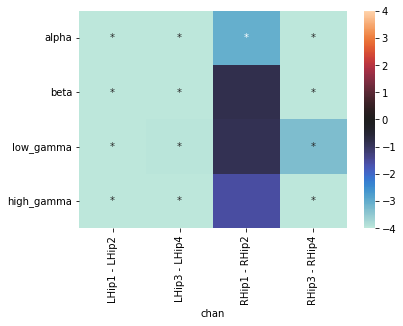

In [ ]:
from scipy.stats import ttest_rel
pvals = []
tvals = []
for hip_ch in hip_chans:
    pvals_for_chan = {'chan': hip_ch}
    tvals_for_chan = {'chan': hip_ch}
    for freq in ['alpha', 'beta', 'low_gamma', 'high_gamma']:
        df_filtered = pac_and_mem[(pac_and_mem['freq'] == freq) & (pac_and_mem['chan'] == hip_ch)]
        results = tvals_for_chan[freq] = ttest_rel(df_filtered['post_pac'], df_filtered['pre_pac'])
        pvals_for_chan[freq] = results.pvalue
        tvals_for_chan[freq] = results.statistic
        
    pvals.append(pvals_for_chan)
    tvals.append(tvals_for_chan)

pvals = pd.DataFrame(pvals)
pvals = pvals.set_index('chan')
tvals = pd.DataFrame(tvals)
tvals = tvals.set_index('chan')

p_stars = np.where(fdr_bh(pvals.T) < 0.05, '*', '')
sns.heatmap(tvals.T, center=0, annot=p_stars, fmt='', vmin=-4, vmax=4)

In [ ]:
pvals

alpha      beta  low_gamma  high_gamma
chan                                                    
LHip1 - LHip2  0.000025  0.000009   0.000061    0.000005
LHip3 - LHip4  0.000590  0.001257   0.002266    0.000105
RHip1 - RHip2  0.008977  0.425429   0.394025    0.138569
RHip3 - RHip4  0.000062  0.000199   0.005144    0.000029

In [ ]:
tvals

alpha      beta  low_gamma  high_gamma
chan                                                    
LHip1 - LHip2 -6.935565 -7.708557  -6.274368   -8.208118
LHip3 - LHip4 -4.759880 -4.299465  -3.951703   -5.890696
RHip1 - RHip2 -3.031305 -0.820958  -0.879408   -1.570718
RHip3 - RHip4 -5.627692 -4.987393  -3.311427   -6.072240